# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

## Preprocesamiento

### Importamos las librerías

In [124]:
# Importamos las librerías que vamos a necesitar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm.notebook import tqdm
import gzip
from sklearn.preprocessing import MinMaxScaler
from langdetect import detect
from textblob import TextBlob
from wordcloud import WordCloud
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

### Configuraciones

In [2]:
# Le doy formato a los gráficos
# sns.set_style("darkgrid")
sns.set_style("white")
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('figure', titlesize=16)
plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

In [3]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.4f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# Instanciamos método para ver el progreso de las operaciones sobre sobre los dataframes
tqdm.pandas()
# Indicador de tiempo de ejecución
%load_ext autotime

In [4]:
# Definimos si queres procesar el dataset crudo
READ_RAW = False
DETECT_LANG = False
GET_SUBJECTIVITY = False
GET_POLARITY = False

### Carga y limpieza inicial de datos

In [5]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [6]:
if READ_RAW:
    contador = 0
    data_reviews = []
    # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
    # abrira uno de cada tres, y asi.
    n = 10
    for l in tqdm(parse('steam_reviews.json.gz')):
        if contador%n == 0:
            data_reviews.append(l)
        else:
            pass
        contador += 1
    data_reviews = pd.DataFrame(data_reviews)

In [7]:
if READ_RAW:
    data_reviews.to_csv('data_reviews.csv', index_label='index')
else:
    data_reviews = pd.read_csv('data_reviews.csv')
    data_reviews.drop(columns='index', inplace=True)

In [8]:
# Previsualizamos el dataframe
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1000,41.0000,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2000,1386.0000,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1000,1706.0000,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8000,2217.0000,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030368.0000,Product received for free,NaN
4,the_maker988,8.2000,18.0000,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396848.0000,NaN,NaN


In [10]:
# Vemos los missings
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [15]:
# Selecciono las columnas que me interesan
# Descarto las columans que tienen muchos missings
columnas = ['username', 'hours', 'product_id', 'date', 'text']
data_reviews = data_reviews[columnas]
data_reviews.head()

,username,hours,product_id,date,text
0,Chaos Syren,0.1000,725280,2017-12-17,This would not be acceptable as an entertainme...
1,Ariman1,13.2000,328100,2017-08-02,Addictive RPG ! Works fine on linux though it ...
2,freakfantom,0.1000,725280,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.
3,The_Cpt_FROGGY,7.8000,631920,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...
4,the_maker988,8.2000,35140,2018-01-02,"This game was way to linear for me, and compar..."


In [16]:
# Vemos los missings
data_reviews.isna().sum()

username        18
hours         2637
product_id       0
date             0
text          1839
dtype: int64

In [17]:
# Descarto los missings
data_reviews.dropna(axis=0, inplace=True)

In [18]:
# Chqueo que no tengo missings
data_reviews.isna().sum()

username      0
hours         0
product_id    0
date          0
text          0
dtype: int64

In [53]:
# Verifico los tipos de dato
data_reviews.dtypes

username       object
hours         float64
product_id      int64
date           object
text           object
dtype: object

**Games**

In [32]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [20]:
# Previsualizo el dataframe
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.4900,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.9900,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8300,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.9900,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.7900,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.9900,False,773570,NaN,NaN,NaN


In [33]:
# Vemos los missings
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [36]:
# Selecciono las columnas que me interesan
# Descarto la columna 'title' ya que tienen muchos missings y la columns 'app_name' tienen los nombres de los juegos
columnas = ['publisher', 'genres', 'app_name', 'tags', 'specs', 'price', 'id', 'developer', 'sentiment']
data_games = data_games[columnas]
data_games.head()

,publisher,genres,app_name,tags,specs,price,id,developer,sentiment
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.9900,761140,Kotoshiro,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,643980,Secret Level SRL,Mostly Positive
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,670290,Poolians.com,Mostly Positive
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.9900,767400,彼岸领域,NaN
4,NaN,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.9900,773570,NaN,NaN


In [37]:
# Vemos los missings
data_games.isna().sum()

publisher    8052
genres       3283
app_name        2
tags          163
specs         670
price        1377
id              2
developer    3299
sentiment    7182
dtype: int64

In [40]:
# Descarto los missings de 'id' y de 'app_name'
data_games.dropna(axis=0, subset=['id', 'app_name'], inplace=True)

In [41]:
# Vemos los missings
data_games.isna().sum()

publisher    8050
genres       3282
app_name        0
tags          162
specs         669
price        1376
id              0
developer    3297
sentiment    7181
dtype: int64

In [42]:
# Observamos los tipos de dato
data_games.dtypes

publisher    object
genres       object
app_name     object
tags         object
specs        object
price        object
id           object
developer    object
sentiment    object
dtype: object

In [50]:
# Cambio el tipo de dato de la columna 'id' y le cambio el nombre a 'product_id' para que coincida con la del dataframe 'data_reviews' 
data_games['id'] = data_games['id'].astype('int')
data_games.rename(columns={'id':'product_id'}, inplace=True)

In [52]:
# Chequeo los data types
data_games.dtypes

publisher     object
genres        object
app_name      object
tags          object
specs         object
price         object
product_id     int32
developer     object
sentiment     object
dtype: object

### Detección de idioma

In [54]:
# Creamos método para eliminar los caracteres que no sean letras
def cleanText(text):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text = re.sub("[^A-Za-z]"," ",str(text))
    return text

In [55]:
# Trabajaremos sobre una copia del dataset de reviews
df_reviews = data_reviews.copy()

In [56]:
# Aplicamos el método a la columna de texto
df_reviews['text'] = df_reviews['text'].progress_apply(cleanText)

  0%|          | 0/774825 [00:00<?, ?it/s]

In [58]:
# Vemos como quedaron las primeras instancias
df_reviews.head()

,username,hours,product_id,date,text
0,Chaos Syren,0.1000,725280,2017-12-17,This would not be acceptable as an entertainme...
1,Ariman1,13.2000,328100,2017-08-02,Addictive RPG Works fine on linux though it ...
2,freakfantom,0.1000,725280,2017-11-12,
3,The_Cpt_FROGGY,7.8000,631920,2017-12-11,Somewhere on Zibylon Zibyl...
4,the_maker988,8.2000,35140,2018-01-02,This game was way to linear for me and compar...


In [59]:
# Creamos función para detectar idioma
def getLang(text):
    try:
        lang = detect(text)                                     
    except:
        lang = np.NaN
    return lang

In [73]:
if DETECT_LANG:
    df_reviews['lang'] = df_reviews['text'].progress_apply(getLang)
    df_reviews.to_csv('df_reviews.csv', index_label='index')
else:
    df_reviews = pd.read_csv('df_reviews.csv', index_col='index')

In [74]:
# Vemos los diferentes idiomas detectados
df_reviews.lang.unique()

array(['en', nan, 'so', 'pl', 'de', 'it', 'fr', 'ca', 'sw', 'tr', 'af',
       'hr', 'tl', 'no', 'es', 'ro', 'vi', 'nl', 'sq', 'cy', 'pt', 'id',
       'lv', 'et', 'hu', 'lt', 'da', 'sl', 'sk', 'fi', 'sv', 'cs', 'uk'],
      dtype=object)

In [75]:
# Cargo un dataset con los nombres de los idiomas correspondiente a cada código
code = pd.read_csv('lang_code3.csv')
# Y lo convierto en diccionario
code_dict = code.set_index('code').to_dict()['language_name']
# Luego reemplazo el código por el nombre del idioma
df_reviews['lang'] = df_reviews['lang'].map(code_dict)

In [76]:
# Agrupo por idioma y ordeno por cantidad de instancias de cada uno
idiomas = df_reviews.groupby('lang').count()['username'].sort_values(ascending=False)

In [85]:
# Veamos que idiomas tenemos
idiomas.head()

lang
English      685187
Somali        10802
German         8799
Afrikaans      7416
Tagalog        5307
Name: username, dtype: int64

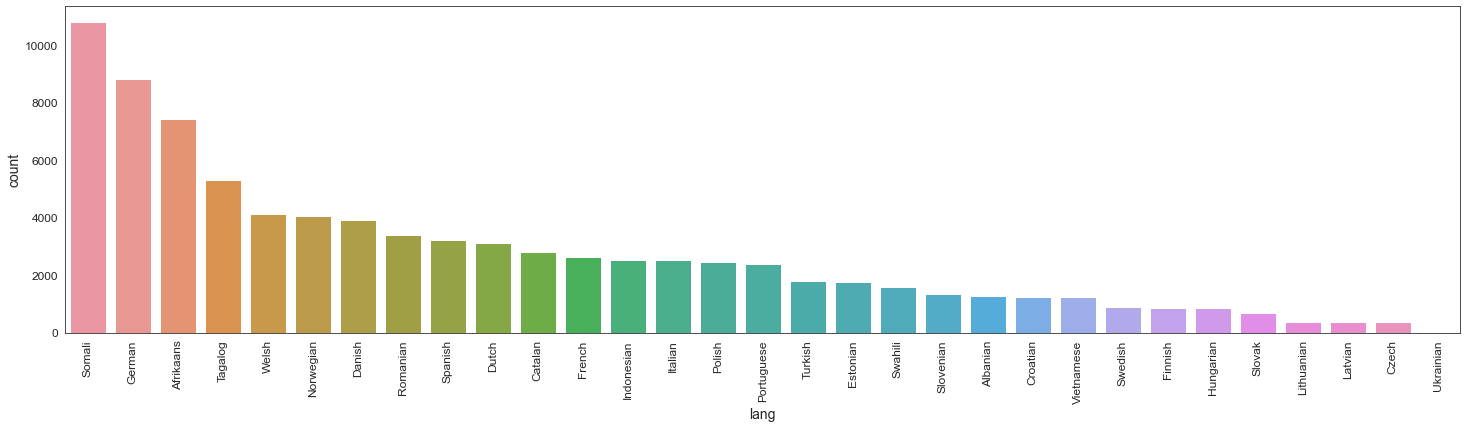

In [86]:
# Graficamos el conteo de los distintos idiomas encontrados en el dataset (además de Inglés)
plt.figure(figsize=(25,6))
sns.countplot(data=df_reviews, x='lang', order=idiomas.index[1:])
plt.xticks(rotation=90)
plt.show()

Vimos claramante que el idioma predominantes es el inglés. Pero algo llamativo es que el segundo más abundante es el "Somalí". Vamos a analizar más en detalle, filtrando esas instancias.

In [87]:
df_reviews[df_reviews.lang == 'Somali'].head(20)

,username,product_id,text,found_funny,hours,lang
index,,,,,,
31,JessetheGengar,302390,baaaddddddd,NaN,0.4000,Somali
247,69:The Best Position,271590,good,NaN,176.3000,Somali
354,Santiago ♥D,308040,bad,1.0000,1.3000,Somali
445,brokensteelcache,224900,too good to play,1.0000,1.3000,Somali
601,𝖊𝖃𝖔 | Psycocat,308040,good game,NaN,3.2000,Somali
617,Vukishaa,308040,good,NaN,3.3000,Somali
698,Dicather,441050,YEAH IT CAN INTO SPACE,NaN,1.6000,Somali
718,MyAcidicPapaya,341720,good,NaN,0.8000,Somali
741,✪ B1ACKOUT,271590,good game,NaN,12.1000,Somali


Por lo que podemos observar, se trata de una mala predicción, ya que los comentarios están en inglés. Por alguna razón (quizás por las faltas de ortografía) los etiqueta como Somalí.
De todos modos, siendo que la cantidad de comentarios predichos como Inglés representan un gran porcentaje, vamos a eliminar aquellas instancias en otro idioma.

In [88]:
mask = df_reviews.lang == 'English'
df_reviews.drop(df_reviews[~mask].index, inplace=True)
df_reviews

,username,product_id,text,found_funny,hours,lang
index,,,,,,
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English
5,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English
...,...,...,...,...,...,...
779301,SepticFalcon,252490,A good laugh with friends cannot wait till mo...,NaN,334.9000,English
779302,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000,English
779304,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000,English


### Tokenización

In [89]:
# Instanciamos el tokenizer
tokenizer=RegexpTokenizer("\w+")

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
stemmer = PorterStemmer()

# Traemos las stopwords
stopwords = set(stopwords.words('english'))

In [90]:
# Creamos método para aplicar la Normalizacion y luega el Stemming a cada instancia
def processText(text):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text=re.sub("[^a-zA-Z]"," ",str(text))
    # Pasamos todo a minúsculas
    text=text.lower()
    # Tokenizamos para separar las palabras del titular
    text=tokenizer.tokenize(text)
    # Eliminamos las palabras de menos de 4 letras
    text = [palabra for palabra in text if len(palabra)>3]
    # Sacamos las Stopwords
    text = [p for p in text if not p in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
#     text = [stemmer.stem(t) for t in text]
    # Por ultimo volvemos a unir el titular
    text = " ".join(text)
    
    return text

In [91]:
# Aplicamos la transformación
df_reviews['cleaned_text'] = df_reviews['text'].progress_apply(processText)

  0%|          | 0/685202 [00:00<?, ?it/s]

In [119]:
# Mostramos el dataset limpio
df_reviews.loc[np.random.choice(df_reviews.index, size=5)]

,username,product_id,text,found_funny,hours,lang,cleaned_text
index,,,,,,,
402546,Fragems,22350,Decent game for or less Definatelty heavi...,NaN,7.8000,English,decent game less definatelty heavily based tho...
596507,Ice,261760,This game is quite good It has challenge str...,NaN,13.7000,English,game quite good challenge stratagey pretty goo...
181469,Malkavian,17460,Have you ever wanted to be sexually attracted ...,NaN,119.6000,English,ever wanted sexually attracted alien
191652,BomBarder307,10680,One of my favorite This game is rly amazing ...,NaN,79.3000,English,favorite game amazing different characters pla...
713183,Vercingettorix,433340,Fun relaxing monster catch game except the mo...,NaN,13.9000,English,relaxing monster catch game except monsters ha...


In [123]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [125]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [152]:
df_reviews['polarity'] = df_reviews['text'].progress_apply(polaridad)

  0%|          | 0/685202 [00:00<?, ?it/s]

In [153]:
df_reviews.head()

,username,product_id,text,found_funny,hours,lang,cleaned_text,pola,rating,polarity
index,,,,,,,,,,
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English,would acceptable entertainment even back graph...,0.2354,3.0885,0.2354
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English,addictive works fine linux though minor bugs r...,0.2023,3.0057,0.2023
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English,somewhere zibylon zibylon command centre read ...,0.9895,4.9737,0.9895
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English,game linear compared others good dollars winte...,0.3818,3.4545,0.3818
5,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English,hello name dominik review bought sudoku detekt...,0.3400,3.3500,0.3400


In [155]:
# Creamos una columns de Rating entre 0 y 5, escalando la columna 'pola'
column=df_reviews[['polarity']]
scaler = MinMaxScaler(feature_range=(0,5))
df_reviews['rating'] = scaler.fit_transform(column)
df_reviews

,username,product_id,text,found_funny,hours,lang,cleaned_text,pola,rating,polarity
index,,,,,,,,,,
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English,would acceptable entertainment even back graph...,0.2354,3.0885,0.2354
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English,addictive works fine linux though minor bugs r...,0.2023,3.0057,0.2023
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English,somewhere zibylon zibylon command centre read ...,0.9895,4.9737,0.9895
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English,game linear compared others good dollars winte...,0.3818,3.4545,0.3818
5,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English,hello name dominik review bought sudoku detekt...,0.3400,3.3500,0.3400
...,...,...,...,...,...,...,...,...,...,...
779301,SepticFalcon,252490,A good laugh with friends cannot wait till mo...,NaN,334.9000,English,good laugh friends cannot wait till added,0.8625,4.6562,0.8625
779302,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000,English,summary rust survival game created facepunch s...,-0.9928,0.0180,-0.9928
779304,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000,English,rust best survival sandbox game market playing...,0.7510,4.3775,0.7510


In [ ]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


def polarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
if GET_SUBJECTIVITY:
    df_reviews['subj'] = df_reviews['text'].progress_apply(subjectivity)
    df_reviews.to_csv('df2_reviews.csv', index_label='index')
else:
    df2_reviews = pd.read_csv('df2_reviews.csv')

In [ ]:
if GET_POLARITY:
    df_reviews['pola'] = df_reviews['text'].progress_apply(polarity)
    df_reviews.to_csv('df2_reviews.csv', index_label='index')
else:
    df2_reviews = pd.read_csv('df2_reviews.csv')

In [ ]:
df2_reviews.sort_values(by='subj').iloc[650000:650050]

In [ ]:
df2_reviews.drop('index', axis=1, inplace=True)

In [ ]:
# Graficamos para ver la distribución de las variables calculadas.

x = df2_reviews.subj[::100]
y = df2_reviews.pola[::100]

plt.figure(figsize=(20,12))
kdeplot = sns.jointplot(x, y, kind="kde", cbar=True, cmap="Blues", fill=True)

plt.subplots_adjust(left=0.1, right=1, top=1, bottom=0.1)

pos_joint_ax = kdeplot.ax_joint.get_position()
pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width,
                               pos_joint_ax.height])
kdeplot.fig.axes[-1].set_position([1.05, pos_joint_ax.y0, .07, pos_joint_ax.height])

# get the current colorbar ticks
cbar_ticks = kdeplot.fig.axes[-1].get_yticks()
# get the maximum value of the colorbar
_, cbar_max = kdeplot.fig.axes[-1].get_ylim()
# change the labels (not the ticks themselves) to a percentage
kdeplot.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 100:.0f} %' for t in cbar_ticks])

kdeplot.fig.axes[0].set_xlabel("Subjectividad")
kdeplot.fig.axes[0].set_ylabel("Polaridad")

plt.show()

In [ ]:
df2_reviews.dropna(axis=0, subset=['username'], inplace=True)
df2_reviews.isna().sum()

In [ ]:
reviews_count = df2_reviews.groupby('username').count().text.sort_values(ascending=False).reset_index().rename(columns={'text':'count'})
reviews_count.head()

In [ ]:
plt.figure(figsize=(30,10))
g = sns.barplot(data=reviews_count[:200], x='username', y='count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
df2_reviews['rating'] = df2_reviews.apply(lambda x: (x['pola'] + 1) * 5/2 , axis=1)

In [ ]:
df2_reviews

In [ ]:
df_ratings = df2_reviews.groupby('product_id').agg({'rating':['count','mean']}).reset_index()
df_ratings.columns = ['product_id', 'count', 'mean']
df_ratings.sort_values(by='mean', ascending=False, inplace=True)
df_ratings.reset_index(inplace=True, drop=True)
df_ratings

In [ ]:
df_filter = df_ratings[df_ratings['count'] >= 100]

plt.figure(figsize=(7,2))
sns.histplot(data=df_filter, x='mean')
plt.ylabel('count')
plt.xlabel('rating')
plt.xticks(rotation=90)
plt.show()

x = df_filter.index
y1 = df_filter['count']
y2 = df_filter['mean']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('game')
ax1.set_ylabel('count', color='g')
ax2.set_ylabel('rating', color='b')

plt.show()

In [40]:
df_games = data_games.copy()
df_games.rename(columns={"id":"product_id"}, inplace=True)
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,product_id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.4900,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.9900,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8300,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.9900,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.7900,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.9900,False,773570,NaN,NaN,NaN


In [43]:
from sklearn.preprocessing import MinMaxScaler
datatypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
normarization = df_reviews.select_dtypes(include=datatypes)
for col in normarization.columns:
    MinMaxScaler(col)
normarization = df_games.select_dtypes(include=datatypes)
for col in normarization.columns:
    MinMaxScaler(col)

In [63]:
df_games = df_games.dropna(subset=['product_id'])

In [64]:
df_games.isna().sum()

publisher          8051
genres             3282
app_name              1
title              2049
url                   0
release_date       2066
tags                162
discount_price    31909
reviews_url           0
specs               669
price              1377
early_access          0
product_id            0
developer          3298
sentiment          7181
metascore         29457
dtype: int64

In [65]:
df_games['product_id'] = df_games['product_id'].astype('int')

In [66]:
df_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
product_id          int32
developer          object
sentiment          object
metascore          object
dtype: object

In [72]:
df = pd.merge(df_reviews, df_games, on="product_id")
df.head()

,username,product_id,text,found_funny,hours,lang,cleaned_text,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English,would acceptable entertainment even back graph...,Vyacheslav Shilikhin,"[Action, Adventure, Indie, Simulation]",Psi Project,Psi Project,http://store.steampowered.com/app/725280/Psi_P...,2017-11-10,"[Action, Adventure, Indie, Simulation]",NaN,http://steamcommunity.com/app/725280/reviews/?...,"[Single-player, Steam Trading Cards]",2.9900,False,Vyacheslav Shilikhin,Positive,NaN
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English,addictive works fine linux though minor bugs r...,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,Gunspell - Steam Edition,http://store.steampowered.com/app/328100/Gunsp...,2014-11-07,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.9900,False,Ino-Co Plus,Mixed,NaN
2,dll3z,328100,do not buy this game,NaN,0.4000,English,game,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,Gunspell - Steam Edition,http://store.steampowered.com/app/328100/Gunsp...,2014-11-07,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.9900,False,Ino-Co Plus,Mixed,NaN
3,Nyazicat,328100,For some reason I entirely derped out and boug...,NaN,2.2000,English,reason entirely derped bought indiegala bundle...,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,Gunspell - Steam Edition,http://store.steampowered.com/app/328100/Gunsp...,2014-11-07,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.9900,False,Ino-Co Plus,Mixed,NaN
4,novocain,328100,Decent match RPG but it s a mobile port of ...,1.0000,3.8000,English,decent match mobile port freemium game managed...,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,Gunspell - Steam Edition,http://store.steampowered.com/app/328100/Gunsp...,2014-11-07,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.9900,False,Ino-Co Plus,Mixed,NaN


In [70]:
df.shape

(685808, 22)

In [69]:
df_reviews.shape

(685202, 7)

In [71]:
df_games.shape

(32133, 16)

In [ ]:
df_games.shape

In [ ]:
df_games.info()

In [ ]:
df_games.isna().sum()

In [ ]:
# Hay dos juegos que no tienen 'id' asociado
# Veamos cuales son
df_games[df_games.id.isna()]

In [ ]:
# df_games.dropna(subset=['id'], axis=0, inplace=True)

In [ ]:
df_games.isna().sum()

In [ ]:
# Me quedo con las columnas: [app_name, release_date, tags, id, sentiment, metascore]
# En vez de quedarme con 'title', para los nombres de los juegos me quedo con 'app_name', ya que title tiene muchos 'NaN'
columns = ['app_name', 'release_date', 'tags', 'id', 'sentiment', 'metascore']

df2_games = data_games[columns]
df2_games.head()

In [ ]:
# Verifico los tipos de datos
df2_games.dtypes

In [ ]:
# Convierto la columns "id" a tipo numérica (integer)
df2_games['id'] = df2_games['id'].astype(str).astype(int)
df2_games.dtypes

In [ ]:
df2_games.head()

In [ ]:
df2_games.info()

In [ ]:
df2_games = df2_games.set_index('id')

In [ ]:
df_filter.info()

In [ ]:
df_filter['app_name'] = df2_games.app_name.loc[df_filter.product_id].values
df_filter['sentiment'] = df2_games.sentiment.loc[df_filter.product_id].values
df_filter.head(20)

In [ ]:
df_filter.dtypes

In [ ]:
df_filter.product_id

In [ ]:
df_filter.shape

In [ ]:
df2_games.app_name.loc[df_filter.product_id.iloc[2]]

In [ ]:
df2_games.loc[df_filter.product_id].app_name.values.shape